<a href="https://colab.research.google.com/github/shashank-m/humour_detection/blob/master/funny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import codecs
from tqdm import tqdm
import spacy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/humour/


funny.ipynb  funny.py  glove.6B.100d.txt  glove.6B.200d.txt  task-1


In [3]:
embeddings_index = {}
#import pre trained fast text embeddings.
f = codecs.open('/content/gdrive/My Drive/Colab Notebooks/humour/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
#     torch_coefs=torch.from_numpy(coefs)
    embeddings_index[word] = coefs
    
        
f.close()

111052it [00:19, 5702.58it/s]


In [8]:



import pandas as  pd
import numpy as np 
import time

alpha=0
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/humour/task-1/train.csv')
print(df.head())
start=time.time()
data_list=[]
# the below code block takes the new word and puts it in the original tweet to make it sound funny.
for row in df.itertuples():
    score=row[-1]
    new_word=row[3]
    original_headline=row[2]
    replaced_word=row[2].split('<')[1].split('>')[0].split('/')[0]
    list_of_words=original_headline.split()
    original_list_of_words=list_of_words
    
    for i,word in enumerate(list_of_words):
        if(word[0]=='<' and word[-1]=='>'):
            alpha=1
            pos_of_replaced_word=i
            break
        if (word[0]=='<'and word[-1]!='>'):
            alpha=-1
            try:
                token=i-1
                pop_1=token+1   
                break
            except:
                # word in beginning
                pop_1=i 
                break
    if alpha==1:
        list_of_words[pos_of_replaced_word]=new_word
    if alpha==-1:
        list_of_words.remove(list_of_words[pop_1])
        list_of_words.remove(list_of_words[pop_1])
        list_of_words.insert(pop_1,new_word)
           
    edited_headline=' '.join(list_of_words)
    
    tup=(replaced_word,original_headline.split(),list_of_words,new_word,score)
    data_list.append(tup)
    
    
        

print('Time taken is {} seconds'.format(time.time()-start))

      id                                           original  ... grades  meanGrade
0  14530  France is ‘ hunting down its citizens who join...  ...  10000        0.2
1  13034  Pentagon claims 2,000 % increase in Russian tr...  ...  33110        1.6
2   8731  Iceland PM Calls Snap Vote as Pedophile Furor ...  ...  22100        1.0
3     76  In an apparent first , Iran and Israel <engage...  ...  20000        0.4
4   6164  Trump was told weeks ago that Flynn misled <Vi...  ...      0        0.0

[5 rows x 5 columns]
Time taken is 0.07718777656555176 seconds


In [0]:
tweet=[]
scores=[]
for tup in data_list:
  t=[i.lower() for i in tup[2]]
  listToStr = ' '.join([str(elem) for elem in t])
  scores.append(tup[-1])
  tweet.append(listToStr)

In [10]:
data=list(zip(tweet,scores))
df=pd.DataFrame(data,columns=['tweet','scores'])
df.head()

,tweet,scores
0,france is ‘ hunting down its citizens who join...,0.2
1,"pentagon claims 2,000 % increase in russian tr...",1.6
2,iceland pm calls snap vote as pedophile furor ...,1.0
3,"in an apparent first , iran and israel slap ea...",0.4
4,trump was told weeks ago that flynn misled sch...,0.0


In [0]:
nlp=spacy.load('en_core_web_sm')

In [0]:
def encode_word(token):
    try:
       return embeddings_index[token.text.lower()]
    except:
        """
        for the case where the embedding for the word doesn't 
        exist in the fast text pretrained file. 
        """
        return np.random.randn(300)
        
def encode_tweet(tweet):
    tokenised=nlp(tweet)
    l=list(map(encode_word,tokenised))
    return np.stack(l,axis=0)

In [0]:
df['encode']=df['tweet'].apply(encode_tweet)


In [0]:
def sh(x):
    return x.shape[0]

In [15]:
max_seq_length=max(df['encode'].apply(sh))
max_seq_length

28

In [0]:
def padding(arr):
    """
    pad the vecotrs so that all examples in the dataset have same seq length 
    (equal to max seq length in dataset)
    """
    seq_length=arr.shape[0]
    dim=arr.shape[1]
    zero_arrays=max_seq_length-seq_length
    zero_array=np.zeros((zero_arrays,dim))
    return np.concatenate((arr,zero_array),0)
df['padded_encode']=df['encode'].apply(padding)

In [0]:
np.random.seed(1)# seed to get the same shuffled dataset everytime.
shuffled=np.random.permutation(df.shape[0])
df.index=shuffled
train_split=int(0.7*df.shape[0])
X_train=df[:train_split]
X_test=df[train_split:]

val_split=int(X_test.shape[0]*0.5)
X_val=X_test[:val_split]
X_test=X_test[val_split:]

y_train=X_train['scores']
y_val=X_val['scores']
y_test=X_test['scores']

X_train=X_train['padded_encode']
X_val=X_val['padded_encode']
X_test=X_test['padded_encode']

#convert series to array.
def series_to_array(series):
    return np.array(series.to_list())
X_train=series_to_array(X_train)
X_val=series_to_array(X_val)
X_test=series_to_array(X_test)
y_train=series_to_array(y_train)
y_val=series_to_array(y_val)
y_test=series_to_array(y_test)

In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

In [19]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [0]:
batch_size=64
train_data=TensorDataset(torch.from_numpy(X_train).float(),(torch.from_numpy(y_train)).float())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)

val_data=TensorDataset(torch.from_numpy(X_val).float(),(torch.from_numpy(y_val)).float())
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=True,drop_last=True)

test_data=TensorDataset(torch.from_numpy(X_test).float(),(torch.from_numpy(y_test)).float())
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=True,drop_last=True)

In [0]:
# build lstm.
class humour_model(nn.Module):
  
  
  def __init__(self,input_dim,hidden_dim,n_layers,drop_prob=0.0):
    torch.manual_seed(1)
    super(humour_model, self).__init__()
    self.input_dim=input_dim
    self.hidden_dim=hidden_dim
    self.n_layers=n_layers
    
    
    # lstm layer.
    # if n_layers==1:
    #   drop_prob=0
    self.lstm=nn.LSTM(self.input_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True,bidirectional=True)
    
    # define a droput layer between fc layer and lstm output.
    self.dropout=nn.Dropout(drop_prob)
    
    # final output/ final hidden state(hidden_state[0]) is passed through a fc layer to get desired output.
    self.feed_forward=nn.Sequential(nn.Linear(hidden_dim,5),nn.ReLU(),nn.Linear(5,1),nn.Sigmoid())
    # define multihead attention layer.
    self.multihead_attn=nn.MultiheadAttention(hidden_dim, 10)
    
  def forward(self,x,hidden):

    out,hidden=self.lstm(x,hidden)
    # out,attn_weights=self.multihead_attn(out,out,out)
    # out,attn_weights=self.multihead_attn(out,out,out)
    # out,attn_weights=self.multihead_attn(out,out,out)
    # out,attn_weights=self.multihead_attn(out,out,out)
    # pass only final hidden state to feedforward network.
    final_hidden=hidden[0].sum(axis=0)
    # ff_input=out[:,-1,:]
    # print(hidden[0].shape)
    # return out
    # print(ff_input.shape)
    output=self.feed_forward(final_hidden)
      
    return output*3

  def init_hidden(self, batch_size):
      ''' Initializes hidden state '''
      # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
      # initialized to zero, for hidden state and cell state of LSTM
      weight = next(self.parameters()).data

      if (is_cuda):
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
      else:
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_(),
                    weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_())

      return hidden

In [22]:
hidden_dim=100
input_dim=X_train.shape[2]
n_layers=1

model=humour_model(input_dim,hidden_dim,n_layers)    
print(next(model.parameters()))

Parameter containing:
tensor([[ 0.0515, -0.0441, -0.0194,  ...,  0.0014, -0.0571, -0.0558],
        [-0.0149, -0.0288,  0.0245,  ..., -0.0258, -0.0014,  0.0983],
        [ 0.0672, -0.0074,  0.0980,  ...,  0.0823, -0.0242,  0.0036],
        ...,
        [ 0.0694,  0.0694,  0.0543,  ...,  0.0024, -0.0604, -0.0383],
        [-0.0641, -0.0177, -0.0897,  ...,  0.0901,  0.0913, -0.0629],
        [-0.0834, -0.0278,  0.0492,  ...,  0.0458,  0.0805,  0.0014]],
       requires_grad=True)


In [0]:

lr=0.00001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=2, last_epoch=-1)

Epoch: 1/80... Step: 100... Loss: 0.736168... Val Loss: 0.768820
Epoch: 2/80... Step: 200... Loss: 0.779316... Val Loss: 0.752619
Epoch: 3/80... Step: 300... Loss: 0.734146... Val Loss: 0.720692
Epoch: 4/80... Step: 400... Loss: 0.708395... Val Loss: 0.692894
Epoch: 5/80... Step: 500... Loss: 0.676235... Val Loss: 0.664176
Epoch: 6/80... Step: 600... Loss: 0.570436... Val Loss: 0.640958
Epoch: 7/80... Step: 700... Loss: 0.582938... Val Loss: 0.616855
Epoch: 8/80... Step: 800... Loss: 0.622070... Val Loss: 0.611203
Epoch: 9/80... Step: 900... Loss: 0.609953... Val Loss: 0.605781
Epoch: 10/80... Step: 1000... Loss: 0.545241... Val Loss: 0.604591
Epoch: 11/80... Step: 1100... Loss: 0.545031... Val Loss: 0.604471
Epoch: 12/80... Step: 1200... Loss: 0.528188... Val Loss: 0.600384
Epoch: 13/80... Step: 1300... Loss: 0.612146... Val Loss: 0.606658
Epoch: 14/80... Step: 1400... Loss: 0.591263... Val Loss: 0.605063
Epoch: 15/80... Step: 1500... Loss: 0.625710... Val Loss: 0.602499
Epoch: 16/80.

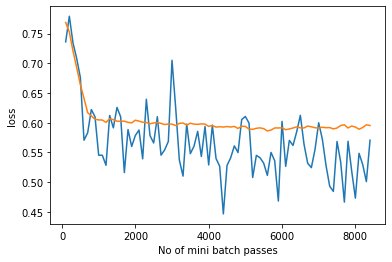

In [24]:
# training loop.
import matplotlib.pyplot as plt
epochs = 80
counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(is_cuda):
    model.cuda()

model.train()
x=[]
y=[]
y_train=[]
for i in range(epochs):
  h = model.init_hidden(batch_size)
  
  # train_losses=[]
  for inputs, labels in train_loader:
      counter += 1

      if(is_cuda):
          inputs, labels = inputs.cuda(), labels.cuda()

      # Creating new variables for the hidden state, otherwise
      # we'd backprop through the entire training history
      h = tuple([each.data for each in h])
      model.zero_grad()

      # get the output from the model
      output=model.forward(inputs,h)
    
      # calculate the loss and perform backprop
      loss = torch.sqrt(criterion(output.squeeze(), labels))
      loss.backward()
      # train_losses.append(loss.item())

      # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()              
  
  # loss stats
     
      if counter % print_every == 0:
          with torch.no_grad():
            # Get validation loss
            x.append(counter)
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval() # putting model to test mode. 
            for inputs, labels in val_loader:

                val_h = tuple([each.data for each in val_h])

                if(is_cuda):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output=model.forward(inputs,h)
                
                val_loss = torch.sqrt(criterion(output.squeeze(), labels))

                val_losses.append(val_loss.item())

            # bring model back to training mode. 
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            
            y.append(np.mean(val_losses))
            y_train.append(loss.item())
          model.train() 
          # train_losses=[]
  # if (i+1)%20==0:
  #   scheduler.step()          

plt.plot(x,y_train)
plt.plot(x,y)
plt.xlabel('No of mini batch passes')
plt.ylabel('loss')
plt.show()

# plt.xlabel('No of mini batch passes')
# plt.ylabel('Train loss')
# plt.show()

In [0]:
# encode sentences.
#glove embeddings.
word_embeddings = {}
f = open('/content/gdrive/My Drive/Colab Notebooks/humour/glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    embedding_for_word = np.asarray(values[1:], dtype='float64')
    word_embeddings[word]=embedding_for_word
    


In [0]:
# can use fast Text for encoding.